# Updated Workfow

Following from the draft workflow, I will now define several functions and generic scripts that will help segregate the input/output and the actual functions.

In [129]:
from pybedtools import BedTool # Note this requires bedtools
from glob import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

In [3]:
# Ensure at top-level directory
os.chdir("../")
os.getcwd()

'/home/work2017/Documents/Jamin'

Current status of dir:

```
.
├── data
│   ├── preprocessed
│   │   ├── markers_lifted
│   │   │   ├── GSM628531_cd4_h2ax_1_lifted.bed
│   │   │   ├── GSM628531_cd4_h2ax_1_lifted.err
│   │   │   ├── GSM628531_cd4_h2ax_2_lifted.bed
│   │   │   ├── GSM628531_cd4_h2ax_2_lifted.err
│   │   │   ├── GSM628532_jurkat_h2ax_1_lifted.bed
│   │   │   ├── GSM628532_jurkat_h2ax_1_lifted.err
│   │   │   ├── GSM628532_jurkat_h2ax_2_lifted.bed
│   │   │   ├── GSM628532_jurkat_h2ax_2_lifted.err
│   │   │   ├── GSM628533_hl60_h2ax_1_lifted.bed
│   │   │   ├── GSM628533_hl60_h2ax_1_lifted.err
│   │   │   ├── GSM628533_hl60_h2ax_2_lifted.bed
│   │   │   ├── GSM628533_hl60_h2ax_2_lifted.err
│   │   │   ├── GSM628534_cd4_rgh2ax_1_lifted.bed
│   │   │   ├── GSM628534_cd4_rgh2ax_1_lifted.err
│   │   │   ├── GSM628534_cd4_rgh2ax_2_lifted.bed
│   │   │   ├── GSM628534_cd4_rgh2ax_2_lifted.err
│   │   │   ├── GSM628535_jurkat_gh2ax_lifted.bed
│   │   │   └── GSM628535_jurkat_gh2ax_lifted.err
│   │   └── mutations_bed
│   │       ├── TCGA.BRCA.muse.6fcfff20-4993-4789-b27b-69d165130466.DR-6.0.somatic.bed
│   │       ├── TCGA.BRCA.mutect.96983226-d92a-449d-8890-e1b210cee0fe.DR-6.0.somatic.bed
│   │       ├── TCGA.BRCA.somaticsniper.8855730e-21ad-4711-9be2-b58bc337834e.DR-6.0.somatic.bed
│   │       └── TCGA.BRCA.varscan.053e3955-5fbd-46d3-8a21-c3cde48ef9b4.DR-6.0.somatic.bed
│   ├── processed
│   └── raw
│       ├── blacklists
│       │   └── hg38.blacklist.bed
│       ├── liftOverchains
│       │   ├── hg18ToHg38.over.chain
│       │   └── hg19ToHg38.over.chain
│       ├── markers
│       │   └── hg18
│       │       ├── GSM628531_cd4_h2ax_1.bed
│       │       ├── GSM628531_cd4_h2ax_2.bed
│       │       ├── GSM628532_jurkat_h2ax_1.bed
│       │       ├── GSM628532_jurkat_h2ax_2.bed
│       │       ├── GSM628533_hl60_h2ax_1.bed
│       │       ├── GSM628533_hl60_h2ax_2.bed
│       │       ├── GSM628534_cd4_rgh2ax_1.bed
│       │       ├── GSM628534_cd4_rgh2ax_2.bed
│       │       └── GSM628535_jurkat_gh2ax.bed
│       ├── markers_other
│       │   ├── GSM628530_cd4_h2a_1.bed
│       │   ├── GSM628530_cd4_h2a_2.bed
│       │   └── GSM628537_input_DNA.bed
│       └── mutations
│           ├── TCGA.BRCA.muse.6fcfff20-4993-4789-b27b-69d165130466.DR-6.0.somatic.maf
│           ├── TCGA.BRCA.mutect.96983226-d92a-449d-8890-e1b210cee0fe.DR-6.0.somatic.maf
│           ├── TCGA.BRCA.somaticsniper.8855730e-21ad-4711-9be2-b58bc337834e.DR-6.0.somatic.maf
│           └── TCGA.BRCA.varscan.053e3955-5fbd-46d3-8a21-c3cde48ef9b4.DR-6.0.somatic.maf
└── src
    ├── 20170625_exploratory.ipynb
    ├── 20170627_draftworkflow.ipynb
    └── 20170628_updatedworkflow.ipynb

13 directories, 44 files
```

# Preprocessing in Bash

## Concatenating .bed files where necessary (GSE25577)

Some of the raw files seem to be split into two. Just a quick script to concatenate the two files...

In [31]:
%%bash

cd data/raw/markers/GSE25577

destination=../GSE25577_concatenated/

for filename in *1.bed;
do
    file_no_dir=${filename##*/}
    file_new_name=${file_no_dir/_1.bed/.bed} 
    cp $filename ../GSE25577_concatenated/$file_new_name
    cat ${filename/1.bed/2.bed} >> ../GSE25577_concatenated/$file_new_name
done

## Converting BigWig to .bed where necessary (GSE97589)

Makes use of bigWigToBed from UCSC command line utilities, and wig2bed from BedOps (http://bedops.readthedocs.io/en/latest/content/reference/file-management/conversion/wig2bed.html)

In [145]:
%%bash

cd data/raw/markers/GSE97589/

for filename in *.bw;
do
    bigWigToWig $filename ${filename/.bw/.wig}
done

In [148]:
%%bash 

cd data/raw/markers/GSE97589/

for filename in *.wig;
do
    wig2bed --zero-indexed < $filename > ${filename/.wig/.bed}
done

## liftOver

In [32]:
%%bash


# LIFTOVER FOR hg18 BED FILES -----------------------------------------------------------------------------
cd data/raw/markers/GSE25577_concatenated
pwd

dir_chain=../../liftOverchains/hg18ToHg38.over.chain
dir_save=../../../preprocessed/markers_lifted/

for filename in *.bed;
do
    liftOver $filename $dir_chain $dir_save${filename/.bed/_lifted.bed} $dir_save${filename/.bed/_lifted.err}
done

/home/work2017/Documents/Jamin/data/raw/markers/GSE25577_concatenated


Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


> NOTE: ensure to keep hg18 files and hg19 files separated...

## Subsetting .maf Based on Clinical/Biospecimen Features

> Still to be done

## Converting .maf to .bed

In [10]:
%%bash

# Ensure data/ lies in your current directory
cd data/raw/mutations/

for filename in *.maf;
do 
    cut -f 5-8 $filename \
    | awk 'NR >= 6 {print}' \
    | awk '$3 = $3 FS "." FS "."' \
    | sed s/" "/"\t"/g \
    > ../../preprocessed/mutations_bed/${filename%.maf}.bed
done

## Sorting Preprocessed .bed files

Since this is needed for the Fisher test, and appears to be more straightforward in bash, I'll do it here...

In [4]:
%%bash

cd data/preprocessed/markers_lifted/

for filename in *.bed;
do
    sort -k1,1 -k2,2n $filename >> ${filename/.bed/_sorted.bed}
done

In [5]:
%%bash

cd data/preprocessed/mutations_bed/

for filename in *.bed;
do
    sort -k1,1 -k2,2n $filename >> ${filename/.bed/_sorted.bed}
done

# Populating the Filter List

hg38 RepeatMasker regions were downloaded from http://genome.ucsc.edu/cgi-bin/hgTables as a .bed file.

This was concatenated with the hg38 blacklist obtained as described previously (20170627) and sorted to produce a full filter list.

In [5]:
%%bash

cd data/raw/blacklists

destination=../../preprocessed/filterlist/filterlist_concat_sorted.bed

cat *.bed | cut -f 1-3 | sort -k1,1 -k2,2n > $destination

# Preliminary Visualisation

Just a test on Jurkat gH2AX and Mutect...

First, filter the beds...

In [7]:
dir_filterlist = "data/preprocessed/filterlist/filterlist_concat_sorted.bed"

dir_marker_bed = "data/preprocessed/markers_lifted/"
name_marker_bed = "GSM628535_jurkat_gh2ax_lifted_sorted.bed"

dir_mutations_bed = "data/preprocessed/mutations_bed/"
name_mutations_bed = "TCGA.BRCA.mutect.96983226-d92a-449d-8890-e1b210cee0fe.DR-6.0.somatic_sorted.bed"

dir_save = "data/preprocessed/filtered_bed/"

filterlist = BedTool(dir_filterlist)
marker_bed = BedTool("".join([dir_marker_bed, name_marker_bed]))
mutations_bed = BedTool("".join([dir_mutations_bed, name_mutations_bed]))

filtered_marker_bed = marker_bed.subtract(filterlist)
filtered_mutations_bed = mutations_bed.subtract(filterlist)

filtered_marker_bed.saveas("".join([dir_save, name_marker_bed.replace(".bed", "_filt.bed")]))
filtered_mutations_bed.saveas("".join([dir_save, name_mutations_bed.replace(".bed", "_filt.bed")]))

<BedTool(data/preprocessed/filtered_bed/TCGA.BRCA.mutect.96983226-d92a-449d-8890-e1b210cee0fe.DR-6.0.somatic_sorted_filt.bed)>

Then cut only the marks and mutations from chromosome 1 for now...

In [29]:
%%bash

cd data/preprocessed/filtered_bed/

marker_name=GSM628535_jurkat_gh2ax_lifted_sorted_filt.bed
mutations_name=TCGA.BRCA.mutect.96983226-d92a-449d-8890-e1b210cee0fe.DR-6.0.somatic_sorted_filt.bed

save_dir=../visualisation_temp/
save_name_marker=jurkat_gh2ax_temp.txt
save_name_mutations=brca_mutect.txt

awk '$1 == "chr1" {print $2, $3}' $marker_name > $save_dir$save_name_marker
awk '$1 == "chr1" {print $2, $3}' $mutations_name > $save_dir$save_name_mutations

Import with numpy...

In [32]:
save_dir = "data/preprocessed/visualisation_temp/"
name_marker = "jurkat_gh2ax_temp.txt"
name_mutations = "brca_mutect.txt"

raw_marker = np.loadtxt("".join([save_dir, name_marker]))
raw_mutations = np.loadtxt("".join([save_dir, name_mutations]))

Just checking that raw_mutations are all length zero (i.e. point mutations)...

In [33]:
max(raw_mutations[:, 0] - raw_mutations[:, 1])

0.0

> TODO: Think of a more efficient way to do this...The below, understandably, takes a long time to run.

The below raises a memory error since it's all done at once rather than interating...

In [ ]:
raw_marker_slice = raw_marker.astype(int)
raw_mutations_slice = raw_mutations.astype(int)

num_rows = raw_marker.shape[0]
num_pos = raw_marker.max * 0.001 # Only taking 0.1% of genome because of memory...

marker_pos = np.zeros([1, num_pos-1])

repeat_array = np.hstack((raw_marker[:, 0] - 1, 
                          raw_marker[:, 1] - raw_marker[:, 0],
                          np.repeat(num_pos, num_rows).reshape([num_rows, 1]) - raw_marker[:, 1]
                         ))

marker_pos = np.repeat([0, 1, 0], repeat_array.flatten(), axis=0).reshape([num_rows, num_pos]).sum(axis=0)

I don't know how long the one below would take to run if I didn't limit the proportion of the chromosome I read...it would take a while, at least half an hour for 10% and possibly about five to ten hours for 100% of a single chromosome.

In [109]:
raw_marker = raw_marker.astype(int)
raw_mutations = raw_mutations.astype(int)

prop_to_read = 0.01 # limit due to memory

num_rows = raw_marker.shape[0]
num_pos = int(raw_marker.max() * prop_to_read)

marker_pos = np.zeros([1, num_pos-1])

for row in raw_marker:
    num_start = row[0]
    num_end = row[1]
    if num_end < num_pos:
        new_vals = np.hstack((np.repeat(0, num_start-1),
                             np.repeat(1, num_end-num_start),
                             np.repeat(0, num_pos-num_end)
                            ))
        marker_pos += new_vals.reshape(1, num_pos-1)
    else:
        break

In [110]:
marker_pos.max()

22.0

In [111]:
bin_width = 30000

num_bins = num_pos // bin_width
max_pos = num_bins * bin_width # There will be clipping at the end

binned_markers = marker_pos[:, 0:max_pos].reshape([num_bins, bin_width]).sum(axis=1)

In [112]:
binned_markers

array([  2.80000000e+03,   2.23300000e+03,   2.28400000e+03,
         5.57000000e+02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   7.76000000e+02,
         5.58000000e+02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.00000000e+02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.98900000e+03,
         3.30400000e+03,   1.40000000e+01,   8.40000000e+01,
         1.84500000e+03,   4.47900000e+03,   1.09350000e+04,
         1.57310000e+04,   1.26210000e+04,   1.45920000e+04,
         5.75660000e+04,   6.89900000e+04,   6.58150000e+04,
         5.67560000e+04,   7.34480000e+04,   6.31400000e+04,
         3.87160000e+04,   4.96570000e+04,   5.74400000e+04,
         3.53060000e+04,   6.87440000e+04,   7.17490000e+04,
         5.34360000e+04,   1.08216000e+05,   2.69240000e+04,
         8.95600000e+03,   6.55000000e+03,   4.63800000e+03,
         3.89600000e+03,

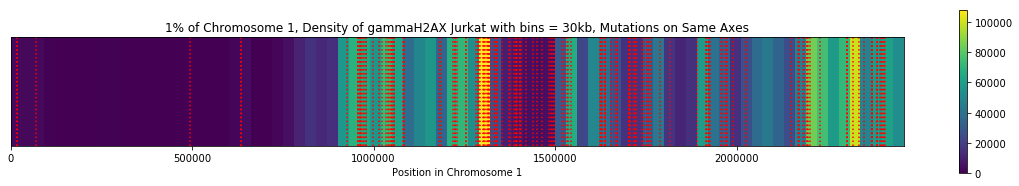

In [142]:
%matplotlib inline


pylab.rcParams['figure.figsize'] = 20, 3

fig, ax1 = plt.subplots(1, 1)
im = ax1.imshow(binned_markers.reshape([1, 82]), extent=[0, 82*bin_width, 0, 10*bin_width])
ax1.set_xlabel("Position in Chromosome 1")
ax1.set_yticks([])
ax1.set_title("1% of Chromosome 1, Density of gammaH2AX Jurkat with bins = 30kb, Mutations on Same Axes")
fig.colorbar(im, ax=ax1)

subset_raw_mutations = raw_mutations[:, 0][raw_mutations[:, 0] <= max_pos]
for point in subset_raw_mutations:
    ax1.axvline(x=point, color="red", linestyle=":")

In [ ]:
ax1 = plt.plot(np.)

Hm. I'm not sure what to make of the above...there looks to be "some" relationship between the position of each, but this could very easily be due to a confounding factor...maybe there needs to be more filtering? As well, it's important to remember I could only plot 1% of a single chromosone (if going for any reasonable execution time)...I guess it was nice to at least attempt visualisation...

# Intersection Function

> Note that this incorporates the filter step within it as well.

In [14]:
def bed_filter_and_intersect(marker_bed, mutations_bed):
    # INPUTS:
    # marker_bed: BedTool object of the coordinates of the marker
    # mutations_bed: BedTool object of the coordinates of the mutations
    # OUTPUTS:
    # A tuple consisting of:
    # - fisher_test: object representing the output from bedtools fisher test (print to see)
    # CANCELLED - prop_intersection: % of marker_bed that intersected with mutations_bed
    # CANCELLED - intersect_bed: BedTool object of the intersections
    
    # Function set variables ------------------------------------------------------------------
    dir_filterlist = "data/preprocessed/filterlist/"
    name_filterlist = "filterlist_concat_sorted.bed"
    
    window_size = 1000 # size of windows around the points for intersection, if using window
    
    # Filtering -------------------------------------------------------------------------------
    
    # Produce blacklist BedTool instance
    filterlist = BedTool("".join([dir_filterlist, name_filterlist]))
    
    # Filter by subtracting blacklist from the original beds
    filtered_marker_bed = marker_bed.subtract(filterlist)
    filtered_mutations_bed = mutations_bed.subtract(filterlist)
    
    # Intersection ----------------------------------------------------------------------------
    
    # Intersection WITH WINDOW
    # intersect_bed = filtered_marker.window(filtered_mutations_bed, w=window_size)
    
    # Intersection WITHOUT WINDOW
    # Using sorted=True as these should have been presorted...docs say uses faster algorithm...
    intersect_bed = filtered_marker_bed.intersect(filtered_mutations_bed, sorted=True)
    
    # Statistics-------------------------------------------------------------------------------
    
    # Proportion of intersection
    num_intersection = intersect_bed.count()
    num_total = filtered_marker_bed.count()
    prop_intersection = num_intersection / num_total
    
    # For Fisher's exact test
    # Sorting first as bedtools documentations mentions that this is required
    # NOTE: seems that this is sorted such that chr12 comes before chr 2 - is this a problem? 
    # It seems that even the bedtools original would have done this too...
    # NEVERMIND: for the moment, have sorted externally to this script
    # sorted_marker_bed = filtered_marker_bed.sort()
    # sorted_mutations_bed = filtered_mutations_bed.sort()
    fisher_test = filtered_marker_bed.fisher(filtered_mutations_bed, genome="hg38")
    
    # Output ----------------------------------------------------------------------------------
    
    return (fisher_test, prop_intersection, num_intersection, num_total)

There are some questions regarding the intersection that I have:

1. There is the possibility of using the window, but it appears this greatly increases the number of intersections. I wonder if the region of $\gamma$-H2AX is sufficient to include that of the mutations - is the window there in case of random shifts?
2. Does strandedness matter? I'm inclined to think not since it doesn't make sense to me how phosphorylated H2AX could be strand-selective, but there are both positive and negative strands in the bed file so I'm not entirely sure what that means...But then from visual inspection of the mutation data, they all seem positive...
3. There are some statistical tests already implemented in BedTools that might be useful: Fisher exact test seems most relevant, but the Jaccard statistics may be useful too. http://bedtools.readthedocs.io/en/latest/content/tools/fisher.html. I feel that unless there is some reason not to, this would not be a bad idea at the moment to use (at least until a better can be found)
4. See the sorting comment in the code above.

# Python Scripts

At this stage, we have done our preprocessing (producing a new set of BED files that can be used directly from Python with `pybedtools`, and need to stitch things together with the function created above.

The data we have preprocessed should be stored in the directories `data/preprocessed/marks_lifted` and `data/preprocessed/mutations_bed`. 

In [ ]:
# INPUT/OUTPUT

dir_markers = "data/preprocessed/markers_lifted/"
dir_mutations = "data/preprocessed/mutations_bed/"

col_names = ["marker_file", "mutation_file", "fisher_stat", "fisher_twotail", 
             "prop_intersection", "num_intersection", "num_total"]

agg_results = pd.DataFrame(columns=col_names)

# As always, need to be wary of the nested for loop...
for file_marker in glob("".join([dir_markers, "*sorted.bed"])):
    for file_mutations in glob("".join([dir_mutations, "*sorted.bed"])):
        print(file_mutations)
        bed_marker = BedTool(file_marker)
        bed_mutations = BedTool(file_mutations)
        results = bed_filter_and_intersect(bed_marker, bed_mutations)
        
        filename_marker = file_marker.replace(dir_markers, "")
        filename_mutations = file_mutations.replace(dir_mutations, "")
        
        data_entry = [[filename_marker, filename_mutations, results[0], results[0].two_tail,
                       results[1], results[2], results[3]]]
        print(data_entry)
        new_row = pd.DataFrame(data_entry, columns=col_names)
        agg_results = agg_results.append(new_row)

In [ ]:
print(agg_results)